In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import asym_funcs as af
import importlib
importlib.reload(af)
import os
import pandas as pd
from matplotlib import rc
from scipy import interpolate
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [2]:
def open_we15file (mydir,myfile):
    
    ds = xr.open_dataset(mydir+myfile)
    ds['names'] = myfile.split('_')[1]
    myday = ds.day
    if 'SolSH' in ds.names.values: # shift by half a year for the SH
        ind = np.append(np.arange(500,1000),np.arange(500))
        ds = ds.isel(day=ind)
        ds['day'] = myday
    # compute ice edge by interpolating E
    iceedge_x = np.asarray([interpolate.interp1d(ds.E.isel(day=d).values, np.linspace(0,1,400))(0.) for d in range(1000)])
    ds['ice_area'] = xr.DataArray(af.a_earth/2.*(1.-iceedge_x), dims=('day'), coords = {'day':myday})
    ds['ice_edge'] = xr.DataArray(np.arcsin(iceedge_x )*180./np.pi , dims=('day'), coords = {'day':myday}) # ice area from sine of latitude
                         
    return ds                       

Read in zonal mean ice edge from observations

In [3]:
zieds = xr.open_dataset('./processed/zonal_ice_edge_CDRv4_1979-1998clim.nc').rename({'time':'day'})
zieds  = af.switch_sh(zieds)
print('Observed zonal mean ice edge is {:.1f}S'.format(zieds.sie_sh_cdr.mean(dim='day').values))

Observed zonal mean ice edge is 64.5S


Read in NOAA zonal mean SSTs

In [4]:
noaasst = xr.open_dataset('./processed/zonalSST_NOAA-OISST_1982-1998clim.nc')

In [5]:
ds = open_we15file ('we15_runs/we15_final_runs/','WE15_SolSH_A194.8_res400.nc')

Plot SST and ice edge in observations and model

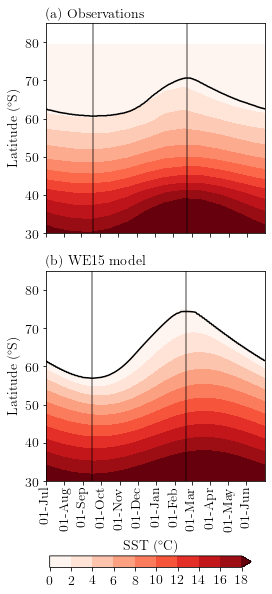

In [6]:
fig = plt.figure(figsize=(4,8))
ax = plt.subplot(2,1,1)
noaasst.sst.plot.contourf(ax=ax, levels = np.arange(0,20,2),cmap = plt.cm.Reds, add_colorbar=False)
a, d1, d2 = af.asym_1d(zieds.sie_sh_cdr.values)
(zieds.sie_sh_cdr).plot(ax=ax,c='k')
ax.axvline(x=d1,c='k', alpha = 0.5)
ax.axvline(x=d2,c='k', alpha = 0.5)
ax.set_xlabel('')
ax.set_title('(a) Observations', loc='left',fontsize=14)
ax.set_ylabel('Latitude ($^{\circ}$S)')
ax.set_ylim([30,85])
ax.set_xticks(af.firstofmonthind )
ax.set_xticklabels(['']*len(af.firstofmonthind ))

ax = plt.subplot(2,1,2)
pl = ds.T.T.plot.contourf(ax=ax, levels = np.arange(0,20,2),cmap = plt.cm.Reds, add_colorbar=False, extend='max')
a, d1, d2 = af.asym_xr(ds.ice_edge, dim='day')
ds.ice_edge.plot(ax=ax,c='k')
ax.axvline(x=ds['day'][int(d1)],c='k', alpha = 0.5)
ax.axvline(x=ds['day'][int(d2)],c='k', alpha = 0.5)
ax.set_ylabel('Latitude ($^{\circ}$S)')
ax.set_ylim([30,85])
ax.set_xticks(af.shfirstofmonthind )
ax.set_xticklabels(af.shfirstofmonthlabel,rotation='vertical')
ax.set_xlabel('')
ax.set_title('')
ax.set_title('(b) WE15 model', loc='left',fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=.15)
cbar_ax = fig.add_axes([0.2, 0.0, 0.7, 0.02])
fig.colorbar(pl, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_title('SST ($^{\circ}$C)',fontsize=14)
plt.show()
fig.savefig('figs/sst_obswe15.pdf',bbox_inches='tight',dpi=300)
plt.close()

Plot ice edge in SolNH, SH and Ideal

In [7]:
myfiles = ['WE15_SolSH_A194.8_res400.nc',
           'WE15_SolIdeal_A195.0_res400.nc',
           'WE15_SolNH_A194.8_res400.nc']

listds = []
for myfile in myfiles:
    ds = open_we15file ('we15_runs/we15_final_runs/', myfile)
    listds.append(ds)
ds = xr.concat(listds,dim='names')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


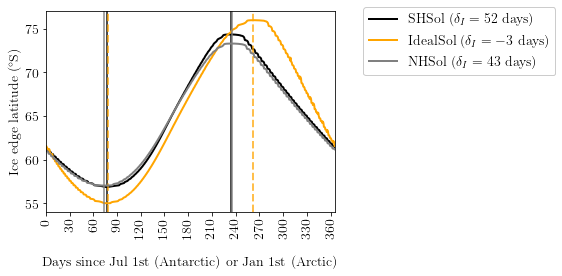

In [8]:
c = ['k','orange','grey']
labels = ['SHSol','IdealSol','NHSol']
fig, ax = plt.subplots(1,figsize=(5,4))
for n, name in enumerate(ds.names.values):
    myds = ds.sel(names=name)
    aday, dmin, dmax = af.asym_xr(myds.ice_area,dim='day')
    aday = aday/1000.*365
    
    myds.ice_edge.plot(ax=ax,c = c[n],linewidth=2,label=labels[n]+' ($\delta_I={0}$ days)'.format(np.round(aday.values).astype(int)))#,c=c[n],linewidth=2)
    ax.axvline(x=ds.day[np.argmin(myds.ice_area.values)],c=c[n],alpha=.7, linestyle=['-','--','-'][n],linewidth=2)
    ax.axvline(x=ds.day[np.argmax(myds.ice_area.values)],c=c[n],alpha=.7, linestyle=['-','--','-'][n],linewidth=2)

ax.set_title('')
ax.set_ylabel('Ice edge latitude ($^{\circ}$S)')
ax.set_xticks(np.arange(1,366,30))
ax.set_xticklabels(np.arange(0,365,30),rotation='vertical')
ax.set_xlabel('Days since Jul 1st (Antarctic) or Jan 1st (Arctic)',labelpad=15)
ax.set_xlim([1,366])
plt.tight_layout()
ax.legend(facecolor='white', framealpha=1, loc=(1.1,.68))
fig.savefig('figs/iceedge_NHSHideal.pdf',bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [9]:
myfiles = ['WE15_SolSH_A194.8_res400.nc',
          'WE15_NoAlbNoTherm_SolSH_A201.6_res400.nc',
          'WE15_NoAlbNoThermNoDiff_SolSH_A138.6_res400.nc',
          'WE15_SolIdeal_A195.0_res400.nc',
          'WE15_NoAlbNoTherm_SolIdeal_A201.5_res400.nc',
          'WE15_NoAlbNoThermNoDiff_SolIdeal_A143.6_res400.nc'] 

listds = []
mydict = {}
for myfile in myfiles:
    ds = open_we15file ('we15_runs/we15_final_runs/',myfile)
    a, dmin, dmax = af.asym_xr(ds.ice_area,dim='day')
    ds['delta'] = a/1000.*365.
    mydict[myfile] = ['{:.1f}'.format(ds.delta.values), '{:.1f}'.format(ds.ice_edge.mean(dim='day').values)]
    listds.append(ds)
    
df = pd.DataFrame(mydict).T
df.columns = ['Delta (days)','Mean ice edge (deg)']
df

,Delta (days),Mean ice edge (deg)
WE15_SolSH_A194.8_res400.nc,51.8,64.8
WE15_NoAlbNoTherm_SolSH_A201.6_res400.nc,37.2,64.6
WE15_NoAlbNoThermNoDiff_SolSH_A138.6_res400.nc,35.0,64.8
WE15_SolIdeal_A195.0_res400.nc,-2.9,65.0
WE15_NoAlbNoTherm_SolIdeal_A201.5_res400.nc,0.0,64.9
WE15_NoAlbNoThermNoDiff_SolIdeal_A143.6_res400.nc,0.0,64.8


Plot WE15 results

In [10]:
siads = xr.open_dataset('./processed/sia_sie_daily_CDRv4_1979-2018.nc').rename({'time':'day'})
siads = af.switch_sh(siads) # switch time axis for SH data
myds = siads.sel(year=slice(1979,1998)).mean(dim='year')
aday, dmin, dmax = af.asym_xr(myds,dim='day')

51.0
At observed mean ice edge, delta_T is 33.66


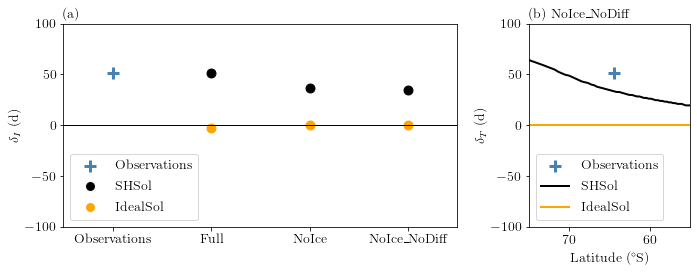

In [11]:
fig = plt.figure(figsize=(10,4))
gs = fig.add_gridspec(1, 6)

ax = fig.add_subplot(gs[0,:4])
ax.axhline(y=0.,c='k',linewidth=1.)
l1 = ax.scatter(-1,aday.sie_sh_cdr,c='steelblue',marker='+',s=150,linewidth=3, label='Observations')
print(aday.sie_sh_cdr.values)
legend_elements = [ l1, Line2D([0], [0], marker='o', color='w', label='SHSol', markerfacecolor='k', markersize=10),
                    Line2D([0], [0], marker='o', color='w', label='IdealSol', markerfacecolor='orange', markersize=10)]
ax.legend(handles=legend_elements, loc='lower left',ncol=1)

for n in range(3):
    ax.scatter(n, listds[n].delta, marker='o',c='k',s=80)

for n in range(3):
    ax.scatter(n, listds[n+3].delta, marker='o',c='orange',s=80)

ax.set_ylim([-100,100])  
ax.set_xlim([-1.5,2.5])
labels = ['Observations','Full','NoIce','NoIce\_NoDiff']
ax.set_xticks(np.arange(-1,len(labels)-1,1))
ax.set_xticklabels(labels)
ax.set_ylabel('$\delta_{I}$ (d)')
ax.set_axisbelow(True)
ax.set_title('(a)',loc='left',fontsize=14)



ax = fig.add_subplot(gs[0,4:])
ax.axhline(y=0.,c='k',linewidth=1.)
ax.set_xlim([75,55])
ax.set_ylim([-100,100])
l1 = ax.scatter(zieds.sie_sh_cdr.mean(dim='day').values,aday.sie_sh_cdr,c='steelblue',marker='+',s=150,linewidth=3,label='Observations')

ds = xr.open_dataset('we15_runs/we15_final_runs/WE15_NoAlbNoThermNoDiff_SolSH_A138.6_res400.nc')
a, _, _ = af.asym_xr(-ds.T,dim='day')
delta = a/1000.*365.
l2, = ax.plot(delta.lat,delta,c='k',linewidth=2,label='SHSol')
print('At observed mean ice edge, delta_T is {:.2f}'.format(delta.interp(lat=zieds.sie_sh_cdr.mean(dim='day').values).values[()]))

ds = xr.open_dataset('we15_runs/we15_final_runs/WE15_NoAlbNoThermNoDiff_SolIdeal_A143.6_res400.nc')
a, _, _ = af.asym_xr(ds.T,dim='day')
delta = a/1000.*365.
l3, = ax.plot(delta.lat,delta,c='orange',linewidth=2,label='IdealSol')

ax.set_xlabel('Latitude ($^\circ$S)')
ax.set_title('(b) NoIce\_NoDiff',loc='left',fontsize=14)
ax.set_ylabel('$\delta_{T}$ (d)')
ax.legend(handles=[l1,l2,l3], loc='lower left',ncol=1)

plt.tight_layout()
plt.show()
fig.savefig('figs/we15_results.pdf',bbox_inches='tight',dpi=300)
plt.close()

Figure for delta as a function of heat capacity

In [12]:
mydir = './we15_runs/we15_cw_runs/'
myfiles = sorted([f for f in os.listdir(mydir) if '.nc' in f])

In [13]:
listds = []
for myfile in myfiles:
    ds = open_we15file ('./we15_runs/we15_cw_runs/', myfile)
    ds = ds.drop('T')
    ds = ds.drop('E')
    ds = ds.drop('lat')
    ds = ds.set_coords('Cw')
    listds.append(ds)
ds = xr.concat(listds,dim='Cw')

9.8 51.83


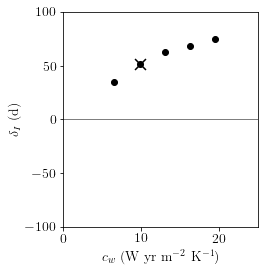

In [15]:
fig, ax = plt.subplots(1,figsize=(4,4))
for ct, Cw in enumerate(ds.Cw.values):
   
    asym, dmin, dmax= af.asym_xr(ds.sel(Cw=Cw).ice_edge,dim='day')
    asym = -asym.values/1000.*365
    ax.scatter(Cw,asym,c='k')
    
    if Cw==9.8:
        print(Cw,asym)
        ax.scatter(Cw,asym,c='k',marker='x',s=120)

ax.set_xlabel('$c_w$ (W yr m$^{-2}$ K$^{-1}$)')
ax.set_ylim([-100,100])
ax.set_ylabel('$\delta_I$ (d)')
ax.axhline(y=0.,c='k',linewidth=.5)
ax.set_xlim([0,25])
plt.tight_layout()
plt.show()
fig.savefig('figs/we15_varcw.pdf')
plt.close()